In [1]:
import tensorflow as tf
import os

# Avoid Out of Memory Error by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

2024-01-10 11:42:30.918475: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 11:42:32.846276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 11:42:32.854985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L3

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from PIL import Image
import shutil
import cv2
import imghdr

def verify_image(image_path):
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
    except Exception as e:
        print('Error: ' + str(e))
        if os.path.basename(image_path) == '.DS_Store':
            os.remove(image_path)
        else:
            shutil.move(image_path, 'Corrupt')   

data_dir = 'BM_cytomorphology_data'
image_exts = ['jpg']

# BM_cytomorphology_data/..
for image_class in os.listdir(data_dir):
    # BM_cytomorphology_data/../..
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):
        for maybe_image in os.listdir(class_path):
            # BM_cytomorphology_data/../../xxxx-xxxx
            if os.path.isdir(os.path.join(data_dir, image_class, maybe_image)):
                for image in os.listdir(os.path.join(data_dir, image_class, maybe_image)):
                    image_path = os.path.join(data_dir, image_class, maybe_image, image)
                    verify_image(image_path)
            # BM_cytomorphology_data/../xxx_xxx.jpg
            else:
                image_path = os.path.join(data_dir, image_class, maybe_image)
                verify_image(image_path)

Load Data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Build data pipline
data = tf.keras.utils.image_dataset_from_directory('BM_cytomorphology_data', image_size=(250, 250))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

label_to_class_mapping = {label: class_name for label, class_name in enumerate(data.class_names)}

label_to_class_mapping

numeric_labels = batch[1]

# Convert numeric labels to class names
class_names = [label_to_class_mapping[label] for label in numeric_labels]

Found 171364 files belonging to 21 classes.


2024-01-10 11:46:06.523870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 11:46:06.524106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 11:46:06.524277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

2. Preprocess Data

2.1 Scale Data

In [4]:
#Scale data from 0-255 to 0-1
data = data.map(lambda image,label: (image/255, label))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()
# data.as_numpy_iterator().next()[0].max()

2024-01-10 11:46:06.956923: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [171364]
	 [[{{node Placeholder/_4}}]]
2024-01-10 11:46:06.957297: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [171364]
	 [[{{node Placeholder/_4}}]]


1.0

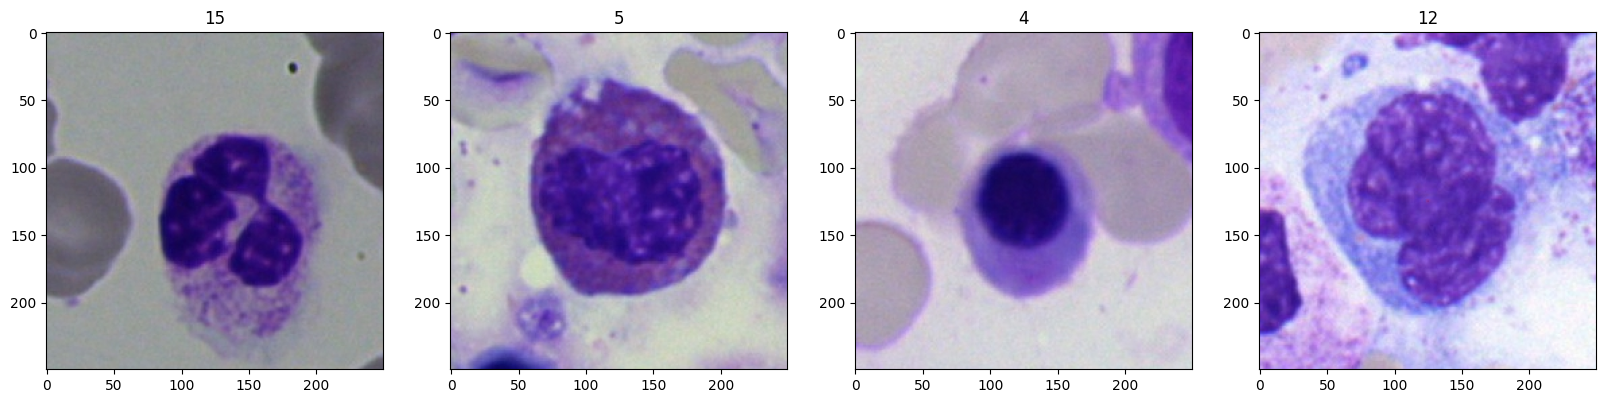

In [5]:
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data

In [6]:
len(data)

5356

In [7]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)

In [8]:
train_size

3749

In [9]:
val_size

1072

In [10]:
test_size

535

In [11]:
train_size + val_size + test_size

5356

In [12]:
# How many batches we want to take for training data
train = data.take(train_size)

# Skip the batches alocated to training partition, then take the data for validation partition
val = data.skip(train_size).take(val_size)

test = data.skip(train_size + val_size).take(test_size)

3. Deep Model

3.1 Build Deep Learning Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation

model = Sequential()
# 16 filters, 3x3 size, stride of 1, 
#0
model.add(Conv2D(8, (3, 3), 1, input_shape=(250, 250, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#1
model.add(Conv2D(8, (3, 3), 1, padding='same'))  # Adjusted the kernel size
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))

#2
model.add(Conv2D(16, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#3
model.add(Conv2D(16, (3, 3), 1, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))

#4
model.add(Conv2D(32, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#5
model.add(Conv2D(32, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))

#6
model.add(Conv2D(64, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#7
model.add(Conv2D(64, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))

model.add(Flatten())

# Fully connected layers
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(21))
model.add(Activation('softmax'))

In [14]:
# Uses adam optimiser
from tensorflow.keras.optimizers import Adam

# initial_learning_rate = 0.001
# optimizer = Adam(learning_rate=initial_learning_rate)

model.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 250, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 8)       584       
                                                                 
 activation_1 (Activation)   (None, 250, 250, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         
 )                                                      

3.2 Training

In [16]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [17]:
import time

t0 = time.time()
hist = model.fit(train, epochs = 50, validation_data = val, callbacks = [tensorboard_callback], verbose = 2)
t1 = time.time()-t0

print('Training time: ', t1)

Epoch 1/50


2024-01-10 11:46:33.211975: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [171364]
	 [[{{node Placeholder/_4}}]]
2024-01-10 11:46:33.212295: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [171364]
	 [[{{node Placeholder/_4}}]]
2024-01-10 11:46:35.286645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-01-10 11:46:35.857655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-1

3749/3749 - 161s - loss: 1.0741 - accuracy: 0.6590 - val_loss: 0.9233 - val_accuracy: 0.7071 - 161s/epoch - 43ms/step
Epoch 2/50
3749/3749 - 152s - loss: 0.8116 - accuracy: 0.7408 - val_loss: 1.0087 - val_accuracy: 0.6814 - 152s/epoch - 41ms/step
Epoch 3/50
3749/3749 - 176s - loss: 0.7364 - accuracy: 0.7633 - val_loss: 0.8673 - val_accuracy: 0.7199 - 176s/epoch - 47ms/step
Epoch 4/50
3749/3749 - 152s - loss: 0.6930 - accuracy: 0.7755 - val_loss: 0.8707 - val_accuracy: 0.7216 - 152s/epoch - 41ms/step
Epoch 5/50
3749/3749 - 153s - loss: 0.6585 - accuracy: 0.7856 - val_loss: 0.7900 - val_accuracy: 0.7461 - 153s/epoch - 41ms/step
Epoch 6/50
3749/3749 - 154s - loss: 0.6304 - accuracy: 0.7930 - val_loss: 0.7107 - val_accuracy: 0.7690 - 154s/epoch - 41ms/step
Epoch 7/50
3749/3749 - 154s - loss: 0.6080 - accuracy: 0.8012 - val_loss: 0.7748 - val_accuracy: 0.7508 - 154s/epoch - 41ms/step
Epoch 8/50
3749/3749 - 153s - loss: 0.5885 - accuracy: 0.8057 - val_loss: 0.7271 - val_accuracy: 0.7669 - 15

3.3 Plot Performance

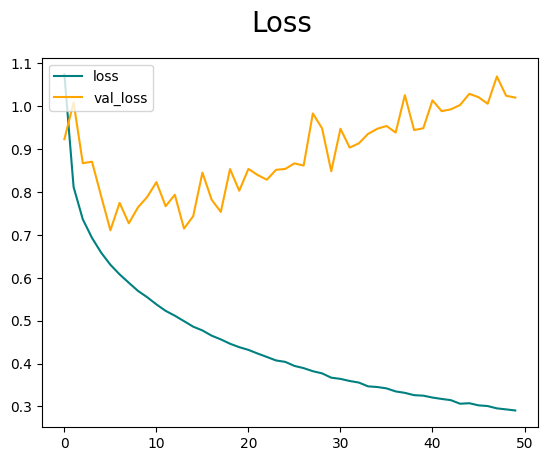

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

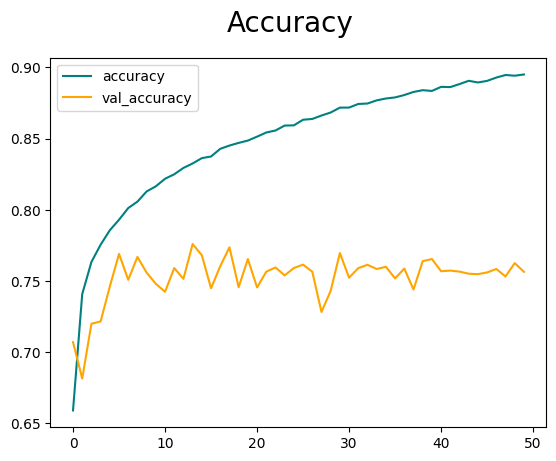

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

In [21]:
import pickle

folder = 'pickle'

with open(os.path.join(folder, 'model_pickle'), 'wb') as f:
    pickle.dump(model, f)

In [22]:
with open(os.path.join(folder, 'history_pickle'), 'wb') as f:
    pickle.dump(hist.history, f)

4. Evaluate Performance

4.1 Evaluate

In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [24]:
precision_per_class = [tf.keras.metrics.Precision(class_id=i) for i in range(21)]
recall_per_class = [tf.keras.metrics.Recall(class_id=i) for i in range(21)]
accuracy_per_class = [tf.keras.metrics.BinaryAccuracy(threshold=0.0) for _ in range(21)]

In [26]:
y_true = []
y_pred = []

# batch_size = 16
# print("test")

for batch in test.as_numpy_iterator():
    batch_size = len(batch[0])  # Assuming the first element of the batch is the input data
    print(f"Current batch size: {batch_size}")
    image, y = batch
    y_one_hot = tf.one_hot(y, 21)
    yhat = model.predict(image)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)
    
    y_true.extend(np.argmax(y_one_hot, axis = 1))
    y_pred.extend(np.argmax(yhat, axis = 1))
    
    # Had OOM errors previously
    tf.keras.backend.clear_session()

2024-01-10 14:13:12.776928: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [171364]
	 [[{{node Placeholder/_4}}]]
2024-01-10 14:13:12.777296: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [171364]
	 [[{{node Placeholder/_4}}]]


Current batch size: 32
1/1 [==============================] - 0s 169ms/step
Current batch size: 32
1/1 [==============================] - 0s 75ms/step
Current batch size: 32
1/1 [==============================] - 0s 75ms/step
Current batch size: 32
1/1 [==============================] - 0s 69ms/step
Current batch size: 32
1/1 [==============================] - 0s 63ms/step
Current batch size: 32
1/1 [==============================] - 0s 74ms/step
Current batch size: 32
1/1 [==============================] - 0s 63ms/step
Current batch size: 32
1/1 [==============================] - 0s 65ms/step
Current batch size: 32
1/1 [==============================] - 0s 67ms/step
Current batch size: 32
1/1 [==============================] - 0s 74ms/step
Current batch size: 32
1/1 [==============================] - 0s 78ms/step
Current batch size: 32
1/1 [==============================] - 0s 66ms/step
Current batch size: 32
1/1 [==============================] - 0s 74ms/step
Current batch size: 32
1

In [27]:
from sklearn.metrics import classification_report

print("Total")
print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_labels = [str(i) for i in range(21)]
class_names = [label_to_class_mapping[label] for label in sorted(label_to_class_mapping.keys())]

# Generate classification report with specified labels
class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Total
Precision0.779664158821106, Recall:0.7388836741447449, Accuracy:0.9776225090026855
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         2
         ART       0.80      0.83      0.81      1972
         BAS       0.12      0.14      0.13        42
         BLA       0.63      0.70      0.66      1211
         EBO       0.90      0.90      0.90      2746
         EOS       0.88      0.85      0.87       592
         FGC       0.00      0.00      0.00         7
         HAC       0.24      0.21      0.22        47
         KSC       1.00      0.50      0.67         2
         LYI       0.00      0.00      0.00         8
         LYT       0.81      0.85      0.83      2577
         MMZ       0.26      0.36      0.30       299
         MON       0.46      0.52      0.49       405
         MYB       0.53      0.56      0.54       618
         NGB       0.59      0.56      0.57      1042
         NGS       0.8

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


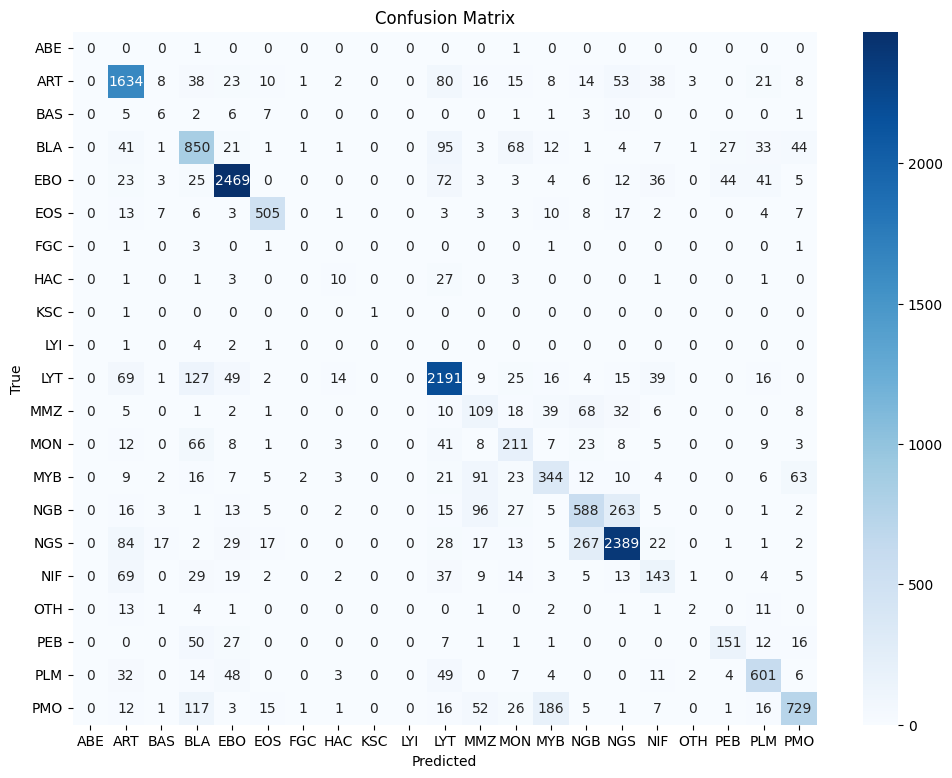

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = np.argmax(y_one_hot, axis=1)
predicted_labels = np.argmax(yhat, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

confusion_data = {
    'conf_matrix': conf_matrix,
    'class_labels': class_names,
}

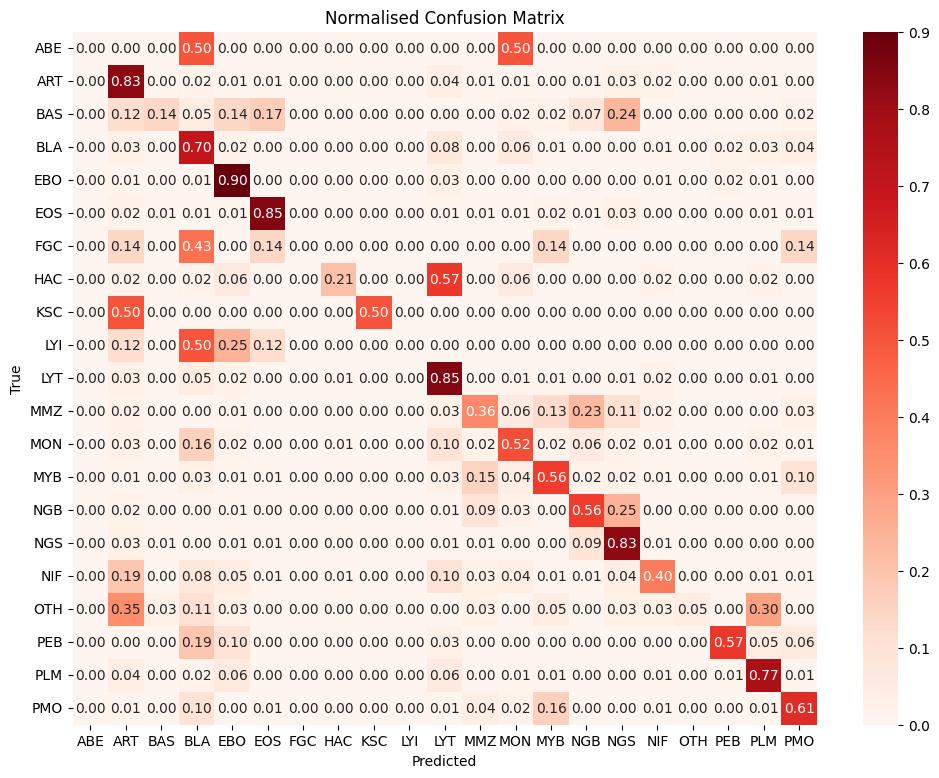

array([1.  , 1.  , 0.99, 1.  , 0.99, 1.01, 0.99, 0.98, 1.  , 0.99, 1.02,
       1.  , 1.  , 1.  , 0.97, 1.01, 0.99, 1.01, 1.  , 1.  , 0.98])

In [30]:
class_totals = np.sum(conf_matrix, axis=1)

normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(class_totals)):
    if class_totals[i] != 0:
        normalised_conf_matrix[i, :] = np.round(conf_matrix[i, :] / class_totals[i], 2)

# # Plot the normalised confusion matrix with class names as tick labels
plt.figure(figsize=(12, 9))
sns.heatmap(normalised_conf_matrix, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

totals = np.sum(normalised_conf_matrix, axis=1)

normalised_confusion_data = {
    'normalised_conf_matrix': normalised_conf_matrix,
    'class_labels': class_names,
}

totals

4.2 Test

In [ ]:
# img = cv2.imread('ART_19001.jpg')
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()

In [ ]:
# resize = tf.image.resize(img, (250,250))
# plt.imshow(resize.numpy().astype(int))
# plt.show()

In [ ]:
# # Model usually predicts multiple images, np.expand_dims encapsulates it into a list
# yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
# yhat
# max_index = np.argmax(yhat)
# print(label_to_class_mapping.get(max_index))

5. Save model & outputs

In [32]:
with open(os.path.join(folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, 'confusion_data'), 'wb') as f:
    pickle.dump(confusion_data, f)
    
with open(os.path.join(folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_confusion_data, f)